# Introduction to Apache Spark Resilient Distributed Datasets (RDD)
## Autor: Paweł Mendroch

### Inicjalizacja Sparka

In [1121]:
!pip install pyspark

In [1122]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [1123]:
spark

In [1124]:
sc = spark.sparkContext

## Dane testowe

In [1125]:
import urllib.request
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7fdef2602978>)

In [1126]:
lines = sc.textFile("apache_logs")

## Zadanie 1 - Narysować wykres rankingu przeglądarek na podstawie pola "user agent" (spróbować pogrupować podobne)

In [1127]:
import re

In [1128]:
regex = '^([(\d\.)]+) - - (\[.*\]) (\"[^\"]*\") .+ .+ \"[^\"]*\" \"([^\"]{2,})\"?$'
regex = re.compile(regex)

Najpierw wyciągam grupę trzecią, reprezentującą user-agent sekcję, następnie ucinam pierwszy znak is splituję po ' ', aby uzyskać listę agentów i wybieram pierwszy rekord.

In [1129]:
def extractBrowser(s):
  matches = re.findall(regex, s)

  if len(matches) > 0:
    # 4th group is the user-agent, then we split by ' ' and get the first agent
    agent = matches[0][3].split(' ')[0]

    if agent != '':
      return (agent, 1)
    else:
      return ('Unknown', 1)
  else:
    return ('Unknown', 1)

In [1130]:
userAgents = lines.map(extractBrowser)

In [1131]:
userAgentsCount = userAgents.reduceByKey(lambda a, b: a + b)

In [1132]:
topUserAgents = userAgentsCount.sortBy(lambda s: s[1], ascending=False).take(15)

In [1133]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [1134]:
df = pd.DataFrame(topUserAgents, columns=['User-agent', 'Count'])
df

,User-agent,Count
0,Mozilla/5.0,8046
1,UniversalFeedParser/4.2-pre-314-svn,364
2,Mozilla/4.0,332
3,Tiny,198
4,Unknown,190
5,FeedBurner/1.0,108
6,Feedfetcher-Google;,102
7,msnbot/2.0b,96
8,Opera/9.80,85
9,Chef,61


In [1135]:
import matplotlib.pyplot as plt

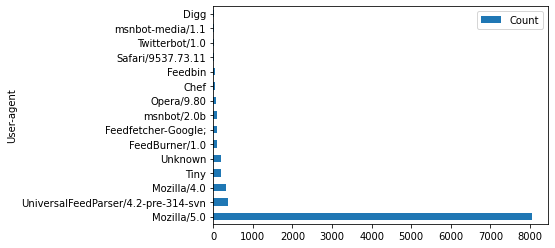

In [1136]:
df.plot.barh(x = 'User-agent')

## Zadanie 2 - Narysować wykres liczby wywołań (request) w zależności od pory dnia (z dokładnością do godziny)

In [1175]:
import re

In [1249]:
regex = '^([(\d\.)]+) - - (\[.*\]) (\"[^\"]*\") .+ .+ \"[^\"]*\" \"([^\"]+)\"?$'
regex = re.compile(regex)

dateRegex = ':\d+'
dateRegex = re.compile(dateRegex)

Najpierw wyciągam sekcję zawierającą timestamp, potem wyciągam konkretną godzinę z daty.

In [1250]:
def extractHour(s):
  matches = re.findall(regex, s)

  if len(matches) > 0:
    # 2nd group is the date section
    date = matches[0][1]
    # get the hour and trim the first character
    hour = re.findall(dateRegex, s)[0][1:]

    return (hour, 1)
  else:
    return ('Unknown', 1)

In [1251]:
hours = lines.map(extractHour)

In [1252]:
hoursCount = hours.reduceByKey(lambda a, b: a + b)

In [1253]:
hoursCount = hoursCount.sortBy(lambda s: s[0], ascending=True).collect()

In [1254]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [1255]:
df = pd.DataFrame(hoursCount, columns=['Hour', 'Count'])
df

,Hour,Count
0,00,361
1,01,360
2,02,365
3,03,354
4,04,355
5,05,371
6,06,366
7,07,357
8,08,345
9,09,364


In [1256]:
import matplotlib.pyplot as plt

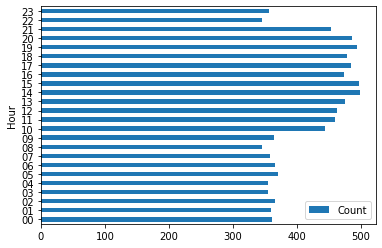

In [1257]:
df.plot.barh(x = 'Hour')

## Zadanie 3 - Narysować wykres rankingu popularności zasobów pobranych metodą HTTP GET

In [1258]:
import re

In [1259]:
regex = '^([(\d\.)]+) - - (\[.*\]) (\"[^\"]*\") .+ .+ \"[^\"]*\" \"([^\"]{2,})\"?$'
regex = re.compile(regex)

Po przefiltrowaniu rekordów zawierających zapytanie typu GET, mogę wyciągnąć zasób z konkretnego zakresu znanków odfiltrowanego stringa.

In [1286]:
def extractResource(s):
  matches = re.findall(regex, s)

  if len(matches) > 0:
    # 3rd group is the resource section
    resourceSection = matches[0][2]
    resource = resourceSection[5:-9]

    return (resource, 1)
  else:
    return ('Unknown', 1)

In [1287]:
resources = lines.filter(lambda s: '] "GET' in s).map(extractResource)

In [1288]:
resourcesCount = resources.reduceByKey(lambda a, b: a + b)

In [1289]:
resourcesCount = resourcesCount.sortBy(lambda s: s[1], ascending=False).take(15)

In [1290]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [1291]:
df = pd.DataFrame(resourcesCount, columns=['Resource', 'Count'])
df

,Resource,Count
0,/favicon.ico,797
1,/style2.css,541
2,/reset.css,533
3,/images/jordan-80.png,533
4,/images/web/2009/banner.png,516
5,/blog/tags/puppet?flav=rss20,488
6,/projects/xdotool/,214
7,/?flav=rss20,194
8,/,191
9,/robots.txt,180


In [1292]:
import matplotlib.pyplot as plt

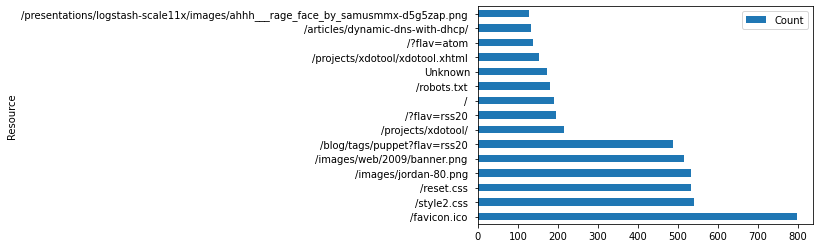

In [1293]:
df.plot.barh(x = 'Resource')

## Zadanie 4 - Narysować wykres (pie chart) popularności systemów operacyjnych klienta

In [1294]:
import re

In [1295]:
regex = '^([(\d\.)]+) - - (\[.*\]) (\"[^\"]*\") .+ .+ \"[^\"]*\" \"([^\"]{2,})\"?$'
regex = re.compile(regex)

systemRegex = '\([^(\(|\))]+\)'
systemRegex = re.compile(systemRegex)

Podobnie jak przy szukaniu przeglądarek, po otrzymaniu grupy z agentami drugim regexem odczytuję dane z nawiasu zawierające system.

In [1312]:
def extractSystem(s):
  matches = re.findall(regex, s)

  if len(matches) > 0:
    # 4th group is the user-agent, then we split by ' ' and extract the system from the first parentheses
    systemGroup = matches[0][3]
    matches = re.findall(systemRegex, systemGroup)
    
    if len(matches) > 0:
      system = matches[0][1:-1]
      return (system, 1)
    else:
      return ('Unknown', 1)
  else:
    return ('Unknown', 1)

In [1313]:
systems = lines.map(extractSystem)

In [1314]:
systemsCount = systems.reduceByKey(lambda a, b: a + b)

In [1315]:
topSystems = systemsCount.sortBy(lambda s: s[1], ascending=False).take(8)

In [1316]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [1317]:
df = pd.DataFrame(topSystems, columns=['System', 'Count'])
df

,System,Count
0,Windows NT 6.1; WOW64,1196
1,Unknown,724
2,Macintosh; Intel Mac OS X 10_9_1,692
3,X11; Linux x86_64,682
4,Windows NT 6.1; WOW64; rv:27.0,296
5,iPhone; CPU iPhone OS 6_0 like Mac OS X,273
6,compatible; Googlebot/2.1; +http://www.google.com/bot.html,237
7,X11; Ubuntu; Linux x86_64; rv:27.0,236


In [1318]:
import matplotlib.pyplot as plt

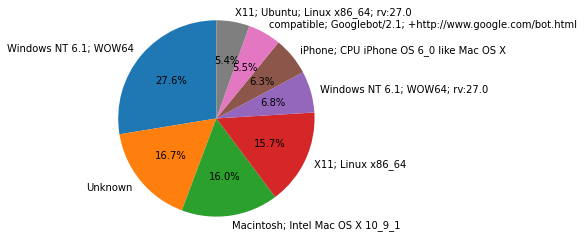

In [1319]:
labels = spark.sparkContext.parallelize(topSystems).map(lambda s: s[0]).collect()
sizes = spark.sparkContext.parallelize(topSystems).map(lambda s: s[1]).collect()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.show()

## Zadanie 5 - Oszacować jaki procent ruchu generują boty

In [1320]:
import re

In [1321]:
regex = '^([(\d\.)]+) - - (\[.*\]) (\"[^\"]*\") .+ .+ \"[^\"]*\" \"([^\"]{2,})\"?$'
regex = re.compile(regex)

systemRegex = '\([^(\(|\))]+\)'
systemRegex = re.compile(systemRegex)

Mój pomysł na znalezienie botów, to sprawdzenie czy w sekcji user-agent znajduje się substring `feed` lub `bot`, co jest prawdziwe przynajmniej dla najpopularniejszych botów.

In [1322]:
def checkIfBot(s):
  matches = re.findall(regex, s)

  if len(matches) > 0:
    # 4th group is the user-agent, we check if feed or bot substrings exist there
    systemGroup = matches[0][3]
    
    if 'feed' in systemGroup or 'bot' in systemGroup:
      return 1

  return 0

In [1323]:
systems = lines.map(checkIfBot)

In [1324]:
botsCount = systems.reduce(lambda a, b: a + b)

In [1325]:
usersCount = lines.count() - botsCount

In [1326]:
import matplotlib.pyplot as plt

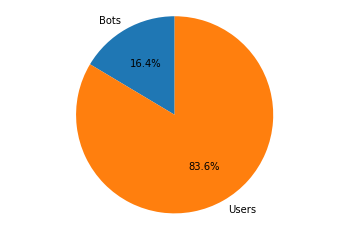

In [1327]:
labels = ['Bots', 'Users']
sizes = [botsCount, usersCount]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.show()